<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="+2"><center> How the sampling distribution of the process time affect inference results </center></font> 

In this notebook, we assess how the sampling distribution of the process time affect inference accuracy with read depth noise and U/S bias fixed by simulations.

Theoretically, we may be able to use Fisher information to get some analytical guidence. 

# Load packages

In [1]:
%cd ..

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.poisson_mixture import PoissonMixture
from RADOM.gamma_poisson_mixture import GammaPoissonMixture
from RADOM.preprocess import *
from RADOM.plotting import *

/home/mffang/workspace/Poisson-regression
2023.04.19.16


In [2]:
import numpy as np
from scipy.stats import spearmanr
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import stats
import copy
from sklearn.decomposition import PCA
import cmasher as cmr

Transcription rates follow exponential distribution with mean 1.

Splicing and degradation rates follow lognormal distribution with mean 1 and sd 1.

Read depth follows Gamma distributions with a coefficient of variation (CV) of 0.5. 

U/S ratio also follows lognormal distribution with mean -1 and sd 1.

For fitting, true read depth is given.

In [3]:
plt.rcParams['font.size'] = '24'
label_font = '36'

lambda_tau = 0

params={"lambda_tau":lambda_tau,"lambda_a":0}

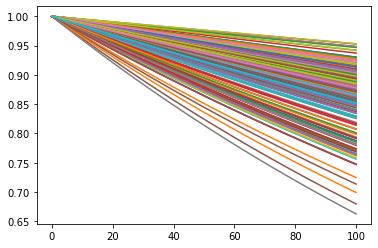

In [394]:
logb_mu = -2
logb_sd = 0.5
beta = np.random.lognormal(logb_mu,logb_sd,size=200).reshape((1,-1))
plt.plot(np.exp(-beta*np.linspace(0,1,101).reshape(-1,1)));

In [363]:
from RADOM.models.two_species_ss import get_Y

def simulate_data(topo, tau, n, p, t_samples=None, loga_mu=2, loga_sd=1, logb_mu=1, logb_sd=0.5, Er=0.1, rd_var=0.25, logu_mu=-1, logu_sd=0, random_seed=2023, loomfilepath=None):    
    np.random.seed(random_seed)
    L=len(topo)
    K=len(tau)-1
    n_states=len(set(topo.flatten()))
    true_t = []
    if t_samples is None:
        t_samples=np.random.uniform(tau[0],tau[-1],size=100*n)
    
    theta=np.zeros((p,n_states+2))
    for j in range(n_states):
        theta[:,j]=np.random.lognormal(loga_mu, loga_sd,size=p)
    theta[:,-2:]=np.random.lognormal(logb_mu,logb_sd,size=(p,2))
    theta[:,:n_states]/=theta[:,-2,None]
    
    Y = np.zeros((n*L,p,2))
    for l in range(L):
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
        t = np.random.choice(t_samples,size=n)
        Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
        true_t = np.append(true_t,t)
    
    if logu_sd != 0:
        Ubias = np.random.lognormal(logu_mu,logu_sd,p)
        Y[:,:,0] *= Ubias[None,:]
    else:
        Ubias = 1
        
    if rd_var != 0:
        read_depth = np.random.gamma(1/rd_var,rd_var,n*L)
        rd = read_depth/read_depth.mean()
    else:
        rd = np.ones(n*L)

    if Er > 0:
        Z = np.random.poisson(Y/Er)
        X = np.random.poisson(rd[:,None,None]*Z*Er)  
    else:
        X = np.random.poisson(rd[:,None,None]*Y)

    
    fig, ax = plt.subplots(1,5,figsize=(30,4))
    ax[0].hist(theta[:,:-2].flatten(),bins=100)
    ax[0].set_title("α")
    ax[1].hist(theta[:,-2:].flatten(),bins=10)
    ax[1].set_title("β and γ")
    ax[2].hist(read_depth,bins=100)
    ax[2].set_title("read depth")
    ax[3].hist(Ubias,bins=100)
    ax[3].set_title("U/S bias")
    ax[4].hist(true_t,bins=100)
    ax[4].set_title("t")
    
    if loomfilepath is not None:
        adata=ad.AnnData(np.sum(X,axis=-1))
        adata.layers["spliced"] = X[:,:,1]
        adata.layers["unspliced"] = X[:,:,0]
        adata.layers["ambiguous"]=np.zeros_like(X[:,:,0])
        adata.obs["time"]=true_t
        adata.obs["celltype"]=topo[(np.arange(n*L)//n),np.array(true_t*K/tau[-1],dtype=int)]
        adata.obs["read_depth"]=read_depth
        adata.uns["theta"]=theta
        adata.var["true_beta"]=theta[:,-2]
        adata.var["true_gamma"]=theta[:,-1]
        adata.var["U_bias"]=Ubias
        adata.write_loom(loomfilepath)
    return theta, true_t, Y, X, rd, Ubias

# 0 --> 1 -->2

In [340]:
#%% generate data
topo=np.array([[0,1,2]])
tau=(0,1,2)

## uniform

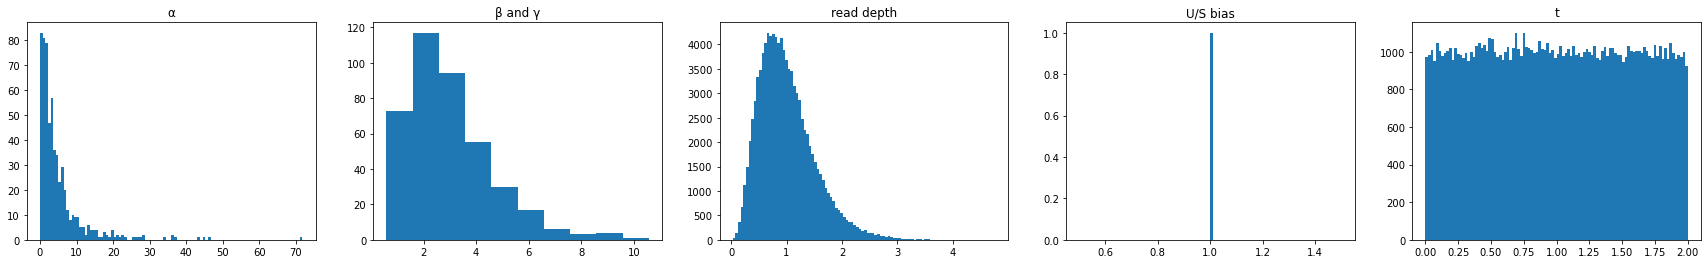

In [376]:
#%% generate data
true_theta, true_t, Y, X1, rd, Ubias = simulate_data(topo,tau,n=100000,p=200,loga_mu=2,logb_sd=0.5,Er=0.1,rd_var=0.25,random_seed=2023)

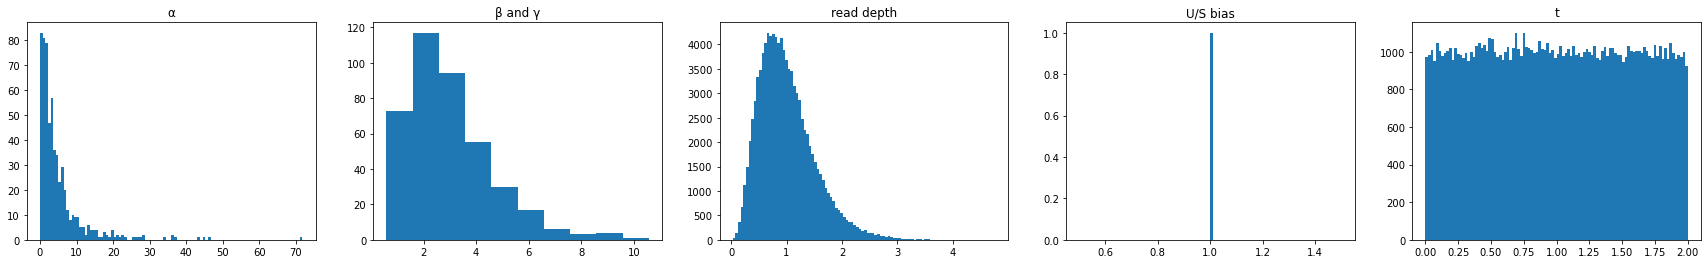

In [377]:
#%% generate data
true_theta, true_t, Y, X2, rd, Ubias = simulate_data(topo,tau,n=100000,p=200,loga_mu=2,logb_sd=0.5,Er=0,rd_var=0.25,random_seed=2023)

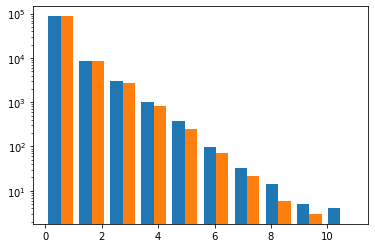

In [378]:
plt.hist([X1[:,0,0],X2[:,0,0]])
plt.yscale('log')

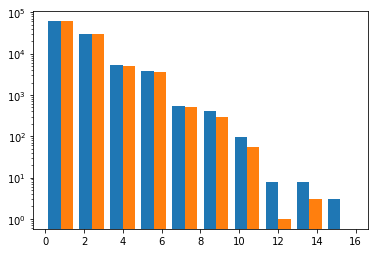

In [379]:
plt.hist([X1[:,0,1],X2[:,0,1]])
plt.yscale('log')

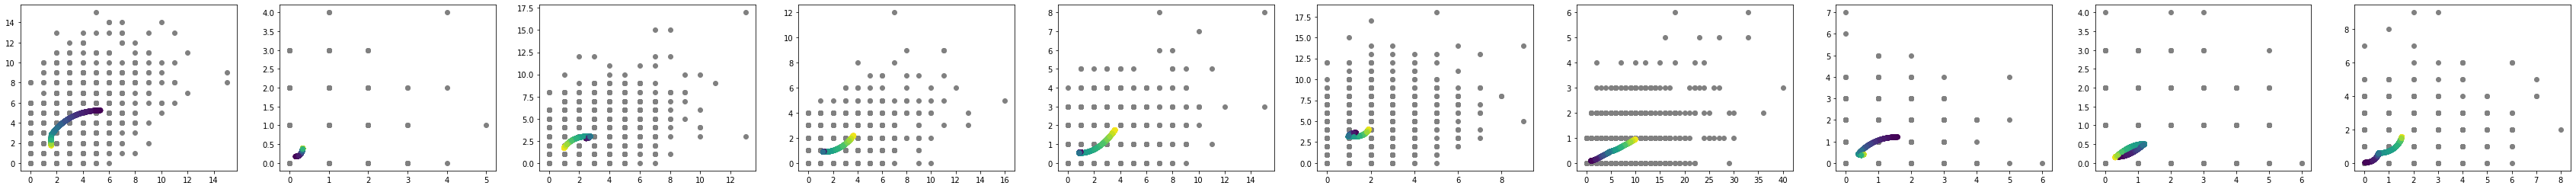

In [322]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    #ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c='gray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c=true_t);
# time increases from blue to red

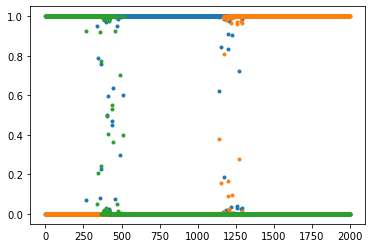

In [323]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X,warm_start=False,read_depth=rd,epoch=10,n_init=5)
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(Q[np.argsort(true_t)],'.');

In [324]:
tau = (0,1,2)
topo = np.array([[0,1,2]])
params={"r":rd,"lambda_a":0}
trajs = []
for seed in tqdm(range(10)):
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

100%|██████████| 10/10 [01:18<00:00,  7.85s/it]


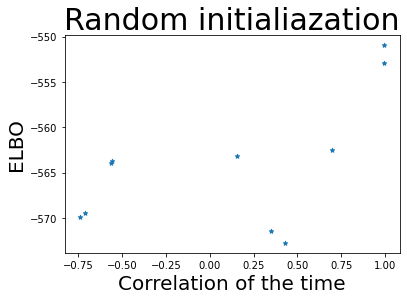

In [325]:
corrs = []
elbos = []
for traj in trajs:
    right_t = true_t.copy()
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1])
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)
traj = trajs[np.argmax(elbos)]

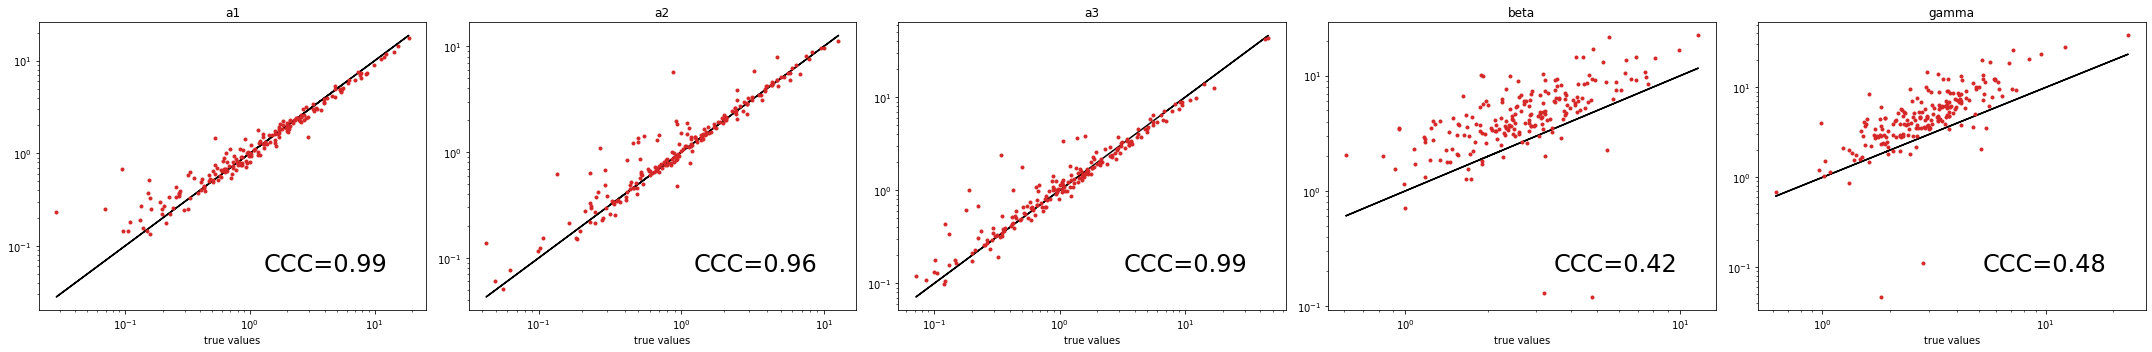

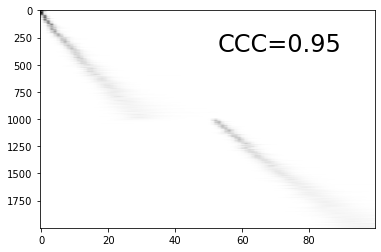

In [326]:
true_theta_ = true_theta.copy()
#true_theta_[:,:-2] *= Ubias[:,None]
plot_theta(true_theta_, traj.theta, dot_color='tab:red');
plot_t(traj,t=true_t,order_cells=True);

## 20% 

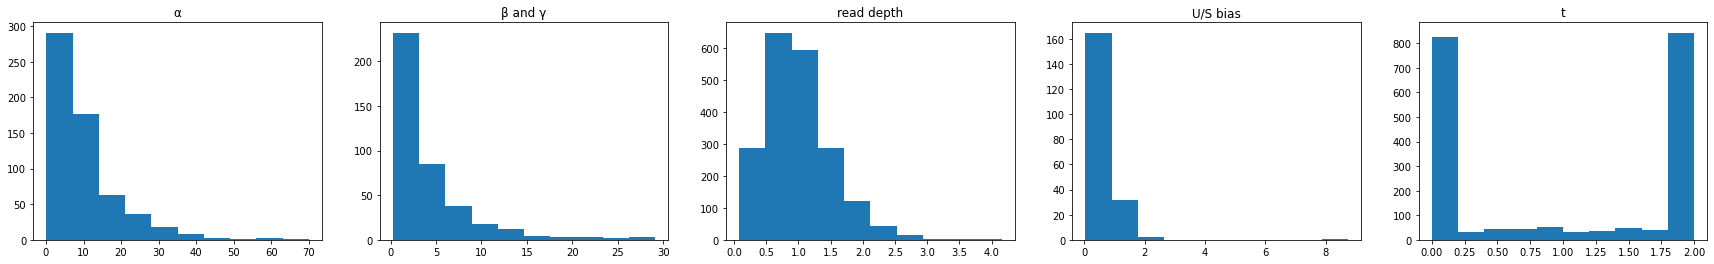

In [50]:
t_samples = np.zeros(10000) 
t_samples[:2000] = np.random.uniform(tau[0],tau[-1],2000)
t_samples[6000:] = tau[-1]
true_theta, true_t, Y, X, rd, Ub = simulate_data(topo, tau, n=2000, p=200, t_samples=t_samples, random_seed=2023)

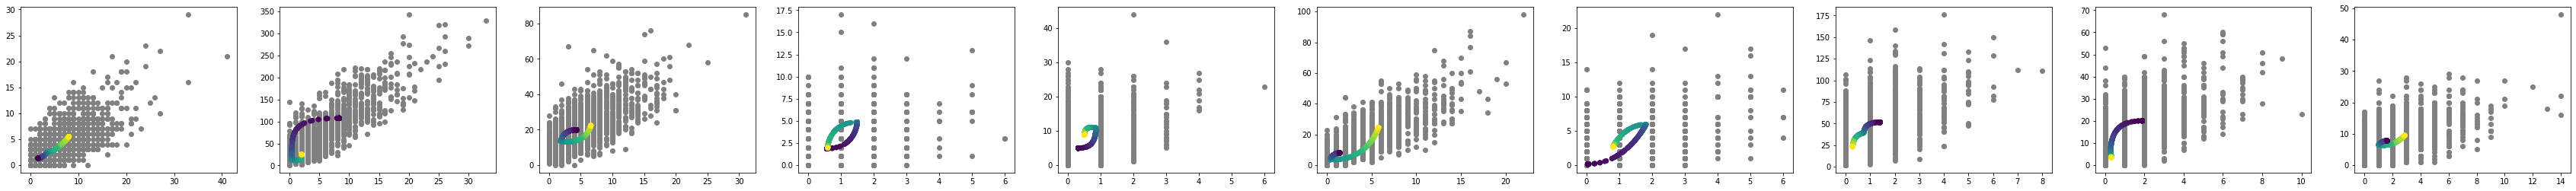

In [51]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    #ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c='gray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c=true_t);
# time increases from blue to red

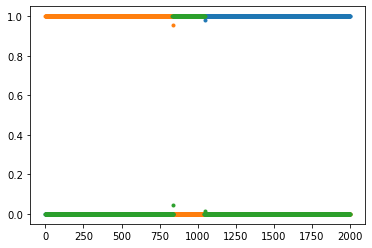

In [52]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X,warm_start=False,read_depth=rd,epoch=10,n_init=5)
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(Q[np.argsort(true_t)],'.');

100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


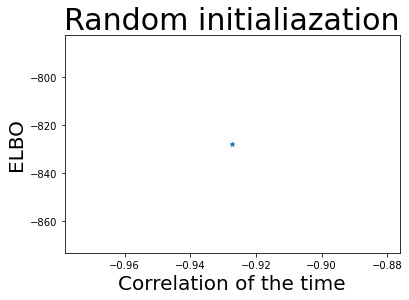

In [53]:
params={"r":rd,"lambda_a":0}
trajs = []
for seed in tqdm(range(1)):
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

corrs = []
elbos = []
for traj in trajs:
    right_t = true_t.copy()
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

traj = trajs[np.argmax(elbos)]

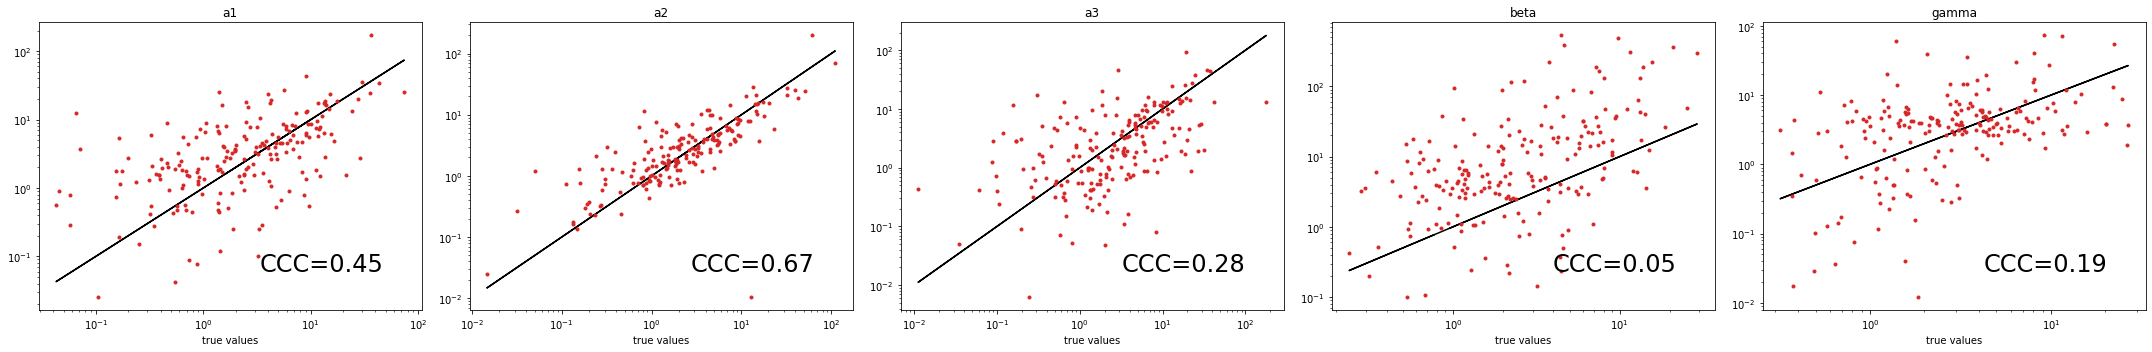

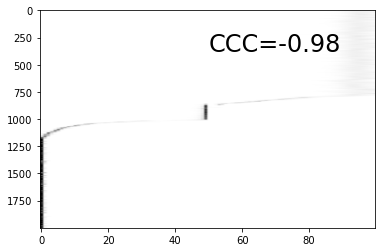

In [54]:
true_theta_ = true_theta.copy()
true_theta_[:,:-2] *= Ub[:,None]
plot_theta(true_theta_, traj.theta, dot_color='tab:red');
plot_t(traj,t=true_t,order_cells=True);

## time points

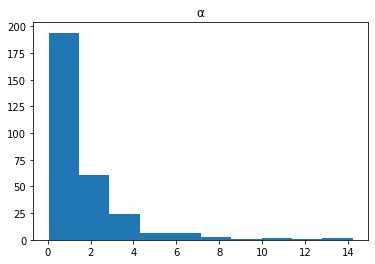

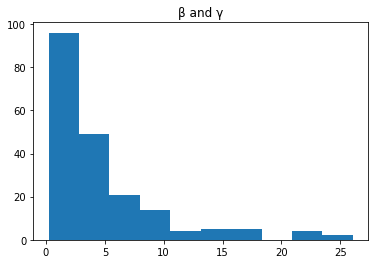

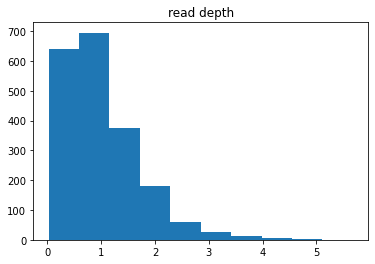

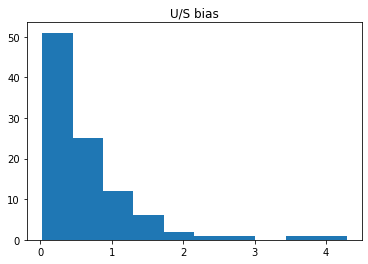

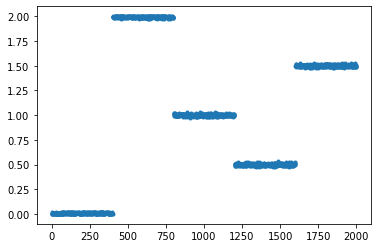

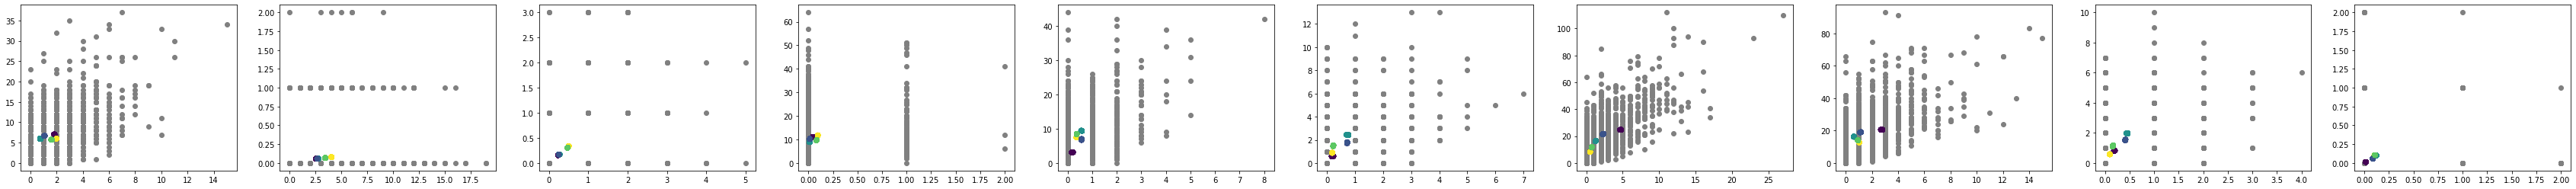

In [20]:
true_theta, true_t, Y, X, rd = simulate_data(topo,tau,n=2000,p=100,random_seed=2023)
plt.figure()
plt.plot(true_t,'.')
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    #ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c='gray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c=true_t);
# time increases from blue to red

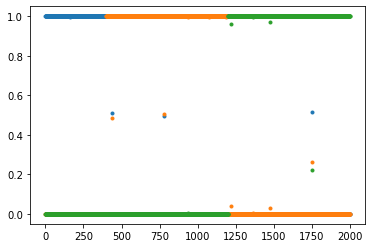

In [21]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X,warm_start=False,read_depth=rd,epoch=10,n_init=5)
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(Q[np.argsort(true_t)],'.');

100%|██████████| 100/100 [07:12<00:00,  4.32s/it]


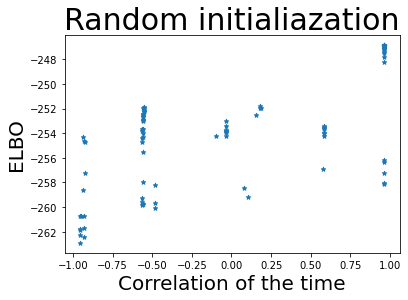

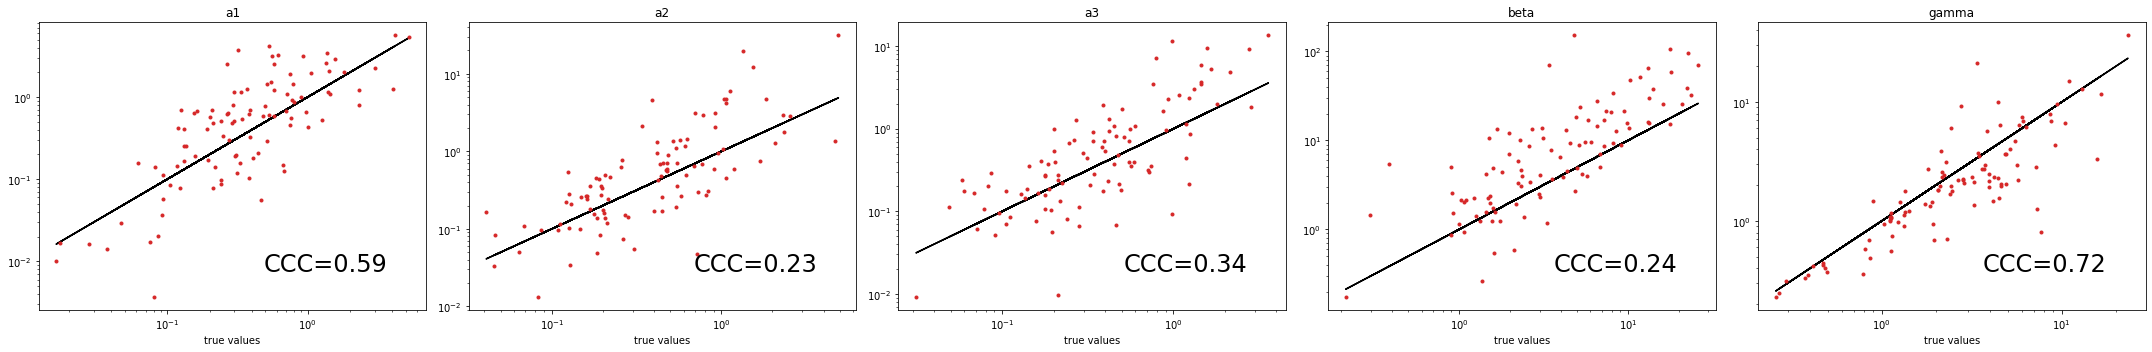

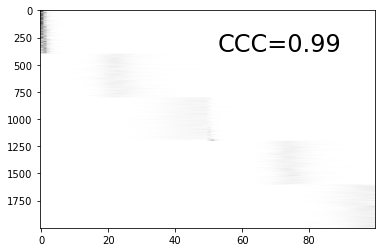

In [22]:
params={"r":rd,"lambda_a":0}
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)
    
corrs = []
elbos = []
for traj in trajs:
    right_t = true_t.copy()
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

traj = trajs[np.argmax(elbos)]
true_theta_ = true_theta.copy()
true_theta_[:,:-2] *= np.exp(-1)
plot_theta(true_theta_, traj.theta, dot_color='tab:red');
plot_t(traj,t=true_t,order_cells=True);

## normal

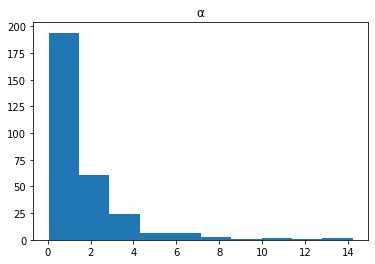

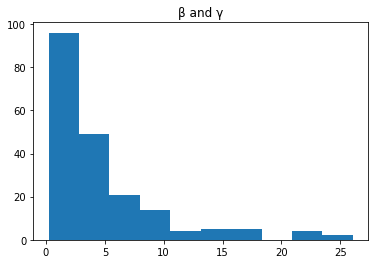

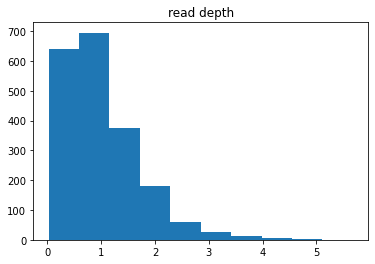

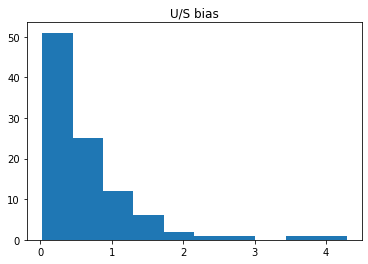

In [24]:
true_theta, true_t, Y, X, rd = simulate_data(topo,tau,n=2000,p=100,random_seed=2023)

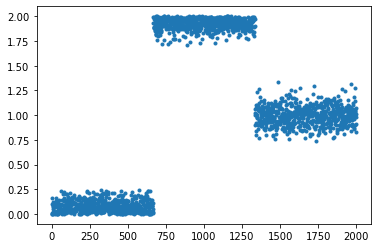

In [25]:
plt.plot(true_t,'.')

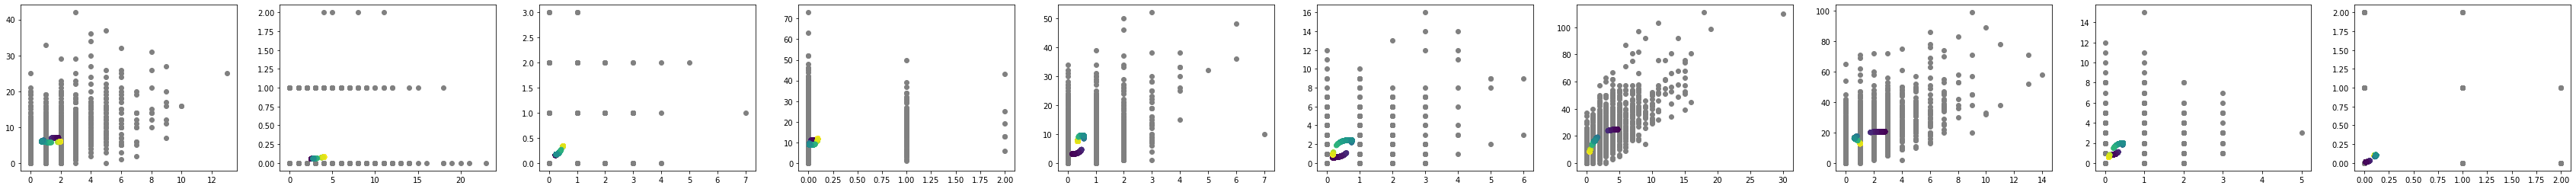

In [26]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    #ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c='gray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c=true_t);
# time increases from blue to red

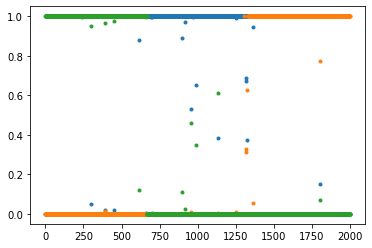

In [27]:
PM = PoissonMixture(n_components=3,verbose=0)
Q, elbo = PM.fit(X,warm_start=False,read_depth=rd,epoch=10,n_init=5)
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(Q[np.argsort(true_t)],'.');

In [28]:
params={"r":rd,"lambda_a":0}
trajs = []
for seed in tqdm(range(100)):
    traj = Trajectory(topo, tau,  model="two_species_ss", restrictions={}, verbose=0)
    traj = traj.fit(X, warm_start=False, params=params, n_init=1, perm_theta=False, parallel=True, epoch=10, n_threads=10, seed=seed)
    trajs.append(traj)

100%|██████████| 100/100 [07:04<00:00,  4.25s/it]


Text(0.5, 1.0, 'Random initialiazation')

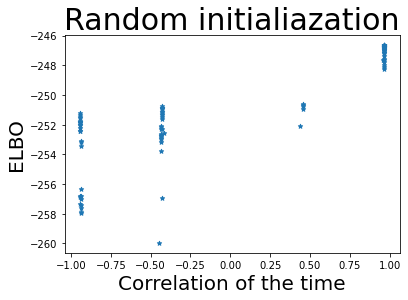

In [29]:
corrs = []
elbos = []
for traj in trajs:
    right_t = true_t.copy()
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(spearmanr(right_t,t_hat)[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,cmap='tab20',s=20,marker='*')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

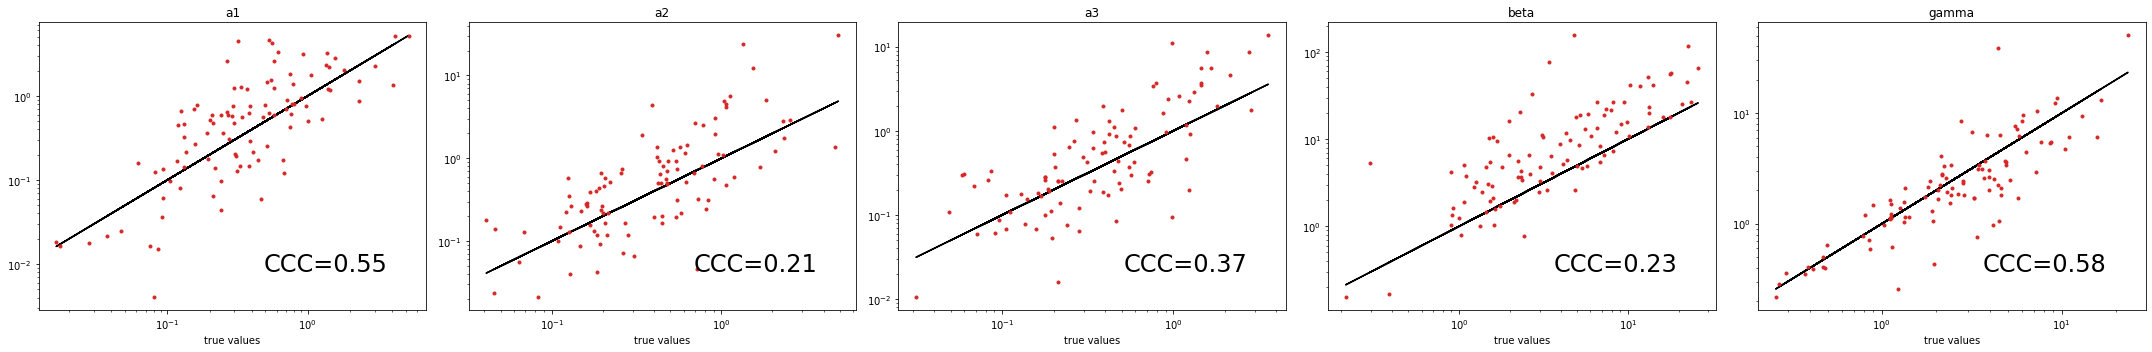

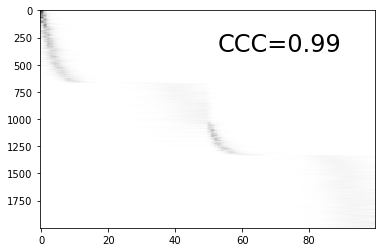

In [30]:
traj = trajs[np.argmax(elbos)]
true_theta_ = true_theta.copy()
true_theta_[:,:-2] *= np.exp(-1)
plot_theta(true_theta_, traj.theta, dot_color='tab:red');
plot_t(traj,t=true_t,order_cells=True);

# Add a bifurcation